# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('/workspace/cd0026/Identify_Customer_Segments/Udacity_AZDIAS_Subset.csv', sep=';');

# Load in the feature summary file.
feat_info = pd.read_csv('/workspace/cd0026/Identify_Customer_Segments/AZDIAS_Feature_Summary.csv', sep=';');

In [3]:
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info.head()


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
adzias_n_rows, adzias_n_cols = azdias.shape
feat_info_n_rows, feat_info_n_cols = feat_info.shape

print("ADZIAS Subset")
print(f"Number of rows: {adzias_n_rows}")
print(f"Number of columns: {adzias_n_cols}\n")
print("ADZIAS Feature Summary")
print(f"Number of rows: {feat_info_n_rows}")
print(f"Number of columns: {feat_info_n_cols}\n")

ADZIAS Subset
Number of rows: 891221
Number of columns: 85

ADZIAS Feature Summary
Number of rows: 85
Number of columns: 4



In [6]:
azdias .info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [7]:
feat_info.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [8]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [9]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
print(feat_info.tail())


      attribute information_level     type missing_or_unknown
80     PLZ8_HHZ    macrocell_plz8  ordinal               [-1]
81     PLZ8_GBZ    macrocell_plz8  ordinal               [-1]
82       ARBEIT         community  ordinal             [-1,9]
83  ORTSGR_KLS9         community  ordinal             [-1,0]
84     RELAT_AB         community  ordinal             [-1,9]


In [11]:
import ast

def parse_missing_value_codes(missing_value_str):
    try:
        return ast.literal_eval(missing_value_str)
    except (ValueError, SyntaxError):
        return []

# Identify missing or unknown data values and convert them to NaNs.
for attribute, miss_index in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    missing_values = parse_missing_value_codes(miss_index)
    if missing_values:
        azdias[attribute] = azdias[attribute].replace(missing_values, np.nan)

In [12]:
azdias.isna().sum().sum()


8372810

In [13]:
azdias.head(10)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,2,1943.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,NaN,2.0,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,4,NaN,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,NaN,1.0,4,NaN,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,5,1964.0,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,NaN,1.0,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,NaN,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,6,1974.0,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,NaN,2.0,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,1,1975.0,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,NaN,2.0,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,NaN,2.0,6.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
num_null = azdias.isna().sum()
num_null

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

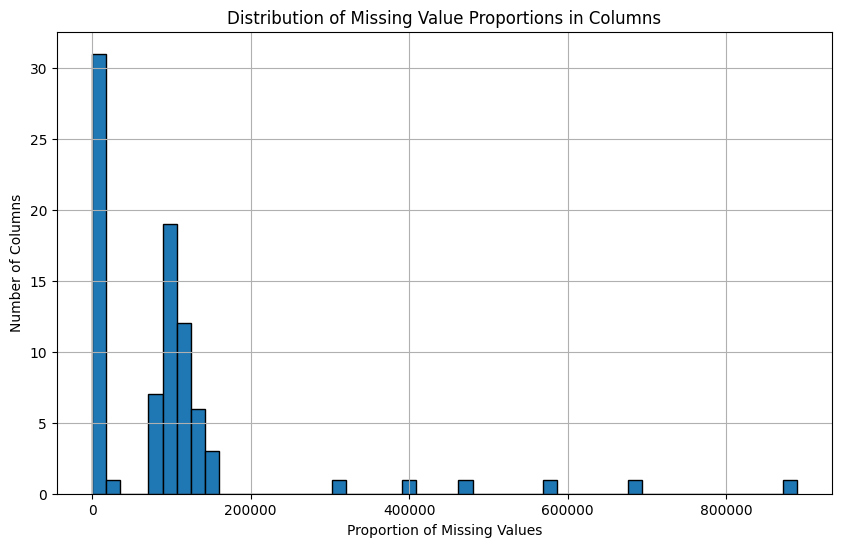

In [15]:
# Investigate patterns in the amount of missing data in each column.
# Plot the histogram of missing value proportions
plt.figure(figsize=(10, 6))
plt.hist(num_null, bins=50, edgecolor='black')
plt.title('Distribution of Missing Value Proportions in Columns')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Number of Columns')
plt.grid(True)
plt.show()

In [16]:
num_null = (num_null/len(azdias))*100
num_null

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

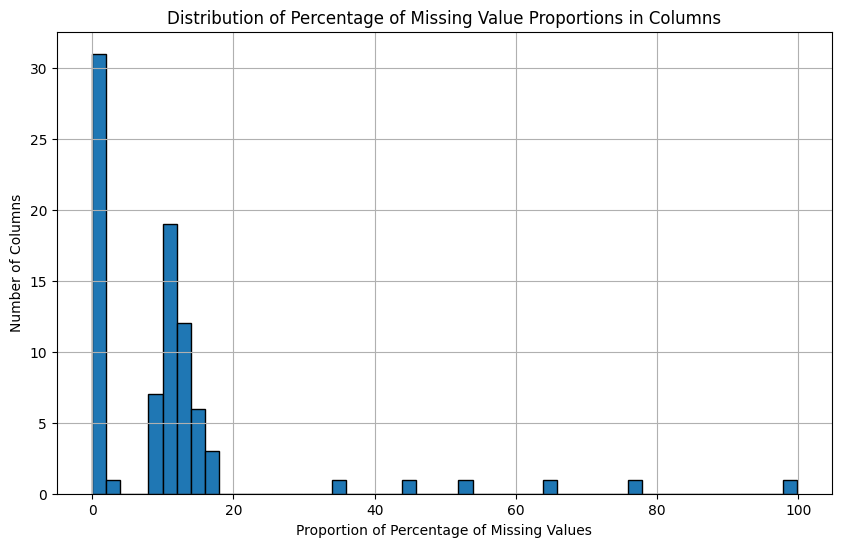

In [17]:
# Plot the histogram of missing value proportions by percent
plt.figure(figsize=(10, 6))
plt.hist(num_null, bins=50, edgecolor='black')
plt.title('Distribution of Percentage of Missing Value Proportions in Columns')
plt.xlabel('Proportion of Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.grid(True)
plt.show()

In [18]:
# Show outliers list
num_null_outlier_cols = num_null[num_null>20]
num_null_outlier_cols

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
num_null_outlier_cols = num_null_outlier_cols.index
new_azdias = azdias.drop(columns=num_null_outlier_cols)

print("Original shape:", azdias.shape)
print("Shape after removing outliers:", new_azdias.shape)

Original shape: (891221, 85)
Shape after removing outliers: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

The histogram identifies columns with a disproportionately high number of missing values. These are the columns where the proportion of missing values is significantly higher than the rest.

Columns with more than 20% missing values:

AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX
These columns are called "Outliers" and they could affect our work negatively, so we've removed them.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
num_null_rows = new_azdias.isna().sum(axis=1)

# Add as a new column to the DataFrame
new_azdias['missing_count'] = num_null_rows

print(new_azdias[['missing_count']].head(10))

   missing_count
0             43
1              0
2              0
3              7
4              0
5              0
6              0
7              0
8              0
9              0


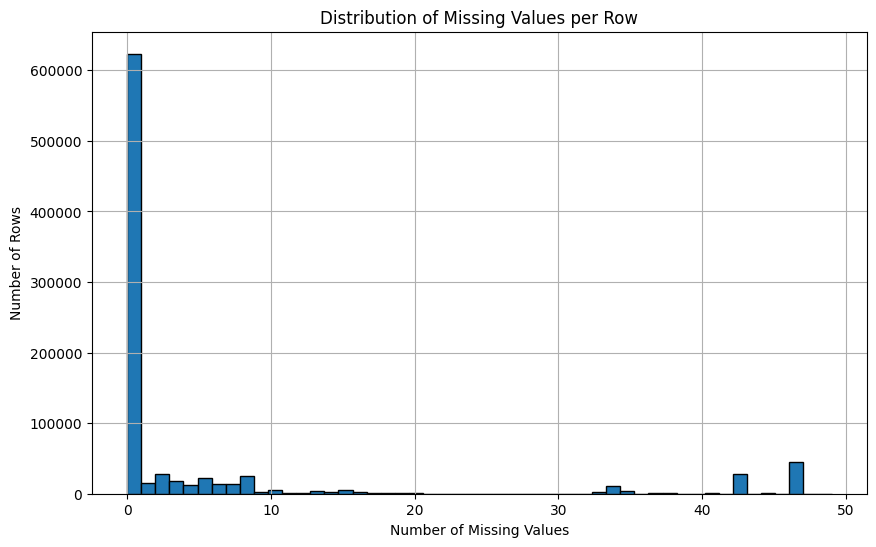

In [21]:
# Plot the histogram of missing values per row
plt.figure(figsize=(10, 6))
plt.hist(num_null_rows, bins=50, edgecolor='black')
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.grid(True)
plt.show()

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Create subsets
azdias_low_missing = new_azdias[new_azdias['missing_count'] <= 30]
azdias_high_missing = new_azdias[new_azdias['missing_count'] > 30]

# Display the sizes of the subsets
print("Rows with few or no missing values:", azdias_low_missing.shape[0])
print("Rows with many missing values:", azdias_high_missing.shape[0])

Rows with few or no missing values: 798067
Rows with many missing values: 93154


In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
import seaborn as sns

def compare_distributions(column, sb1, sb2, title1, title2):

    plt.figure(figsize=(12, 6))

    # Plot for the first subset
    plt.subplot(1, 2, 1)
    sns.countplot(x=column, data=sb1)
    plt.title(title1)

    # Plot for the second subset
    plt.subplot(1, 2, 2)
    sns.countplot(x=column, data=sb2)
    plt.title(title2)

    plt.tight_layout()
    plt.show()

In [24]:
columns=num_null[num_null<20].index


In [25]:
top_few_missing_cols = columns[:5]
top_few_missing_cols

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER'],
      dtype='object')

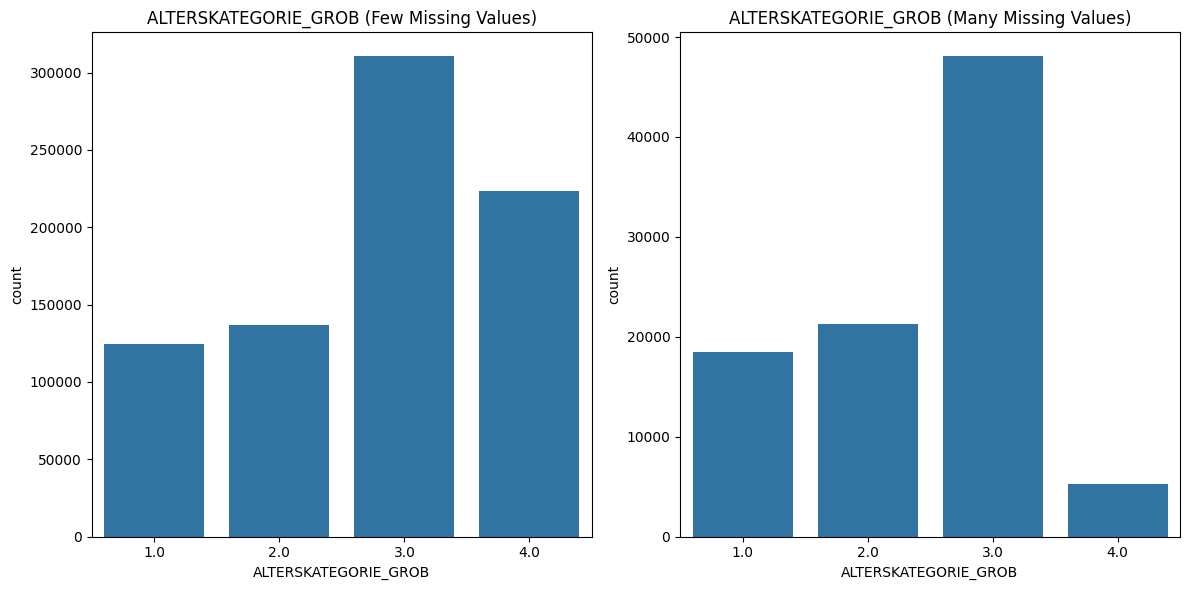

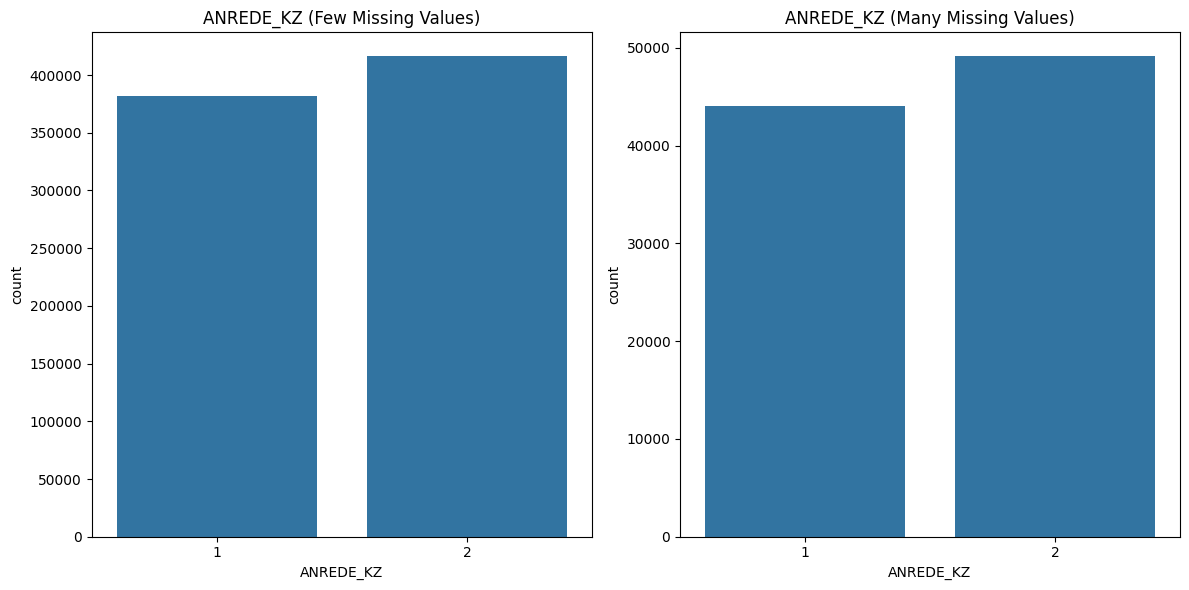

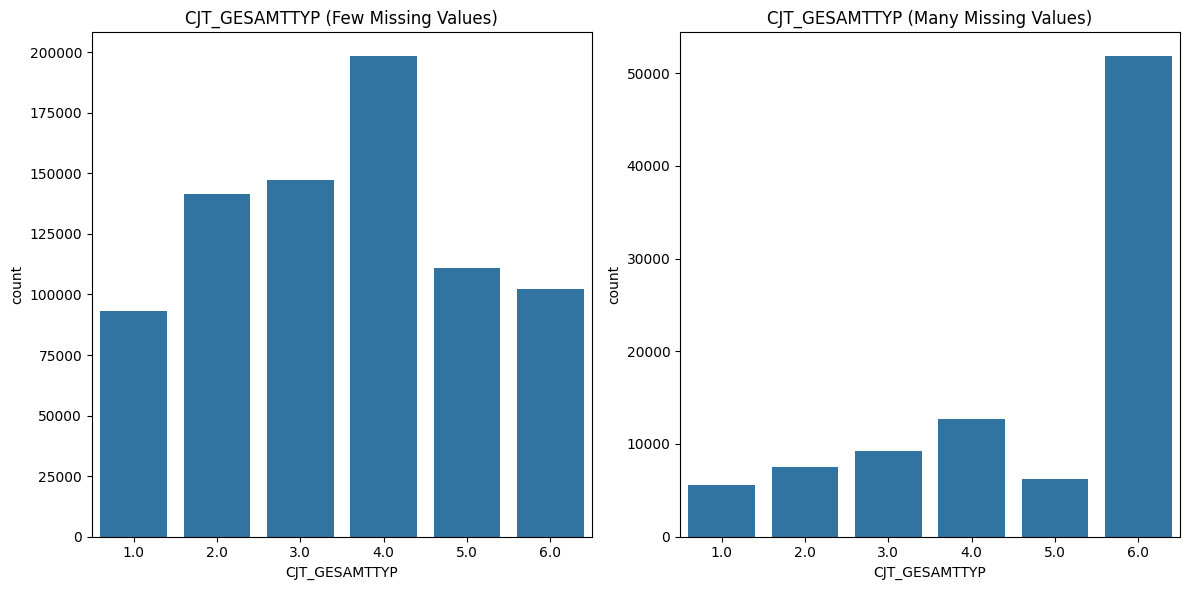

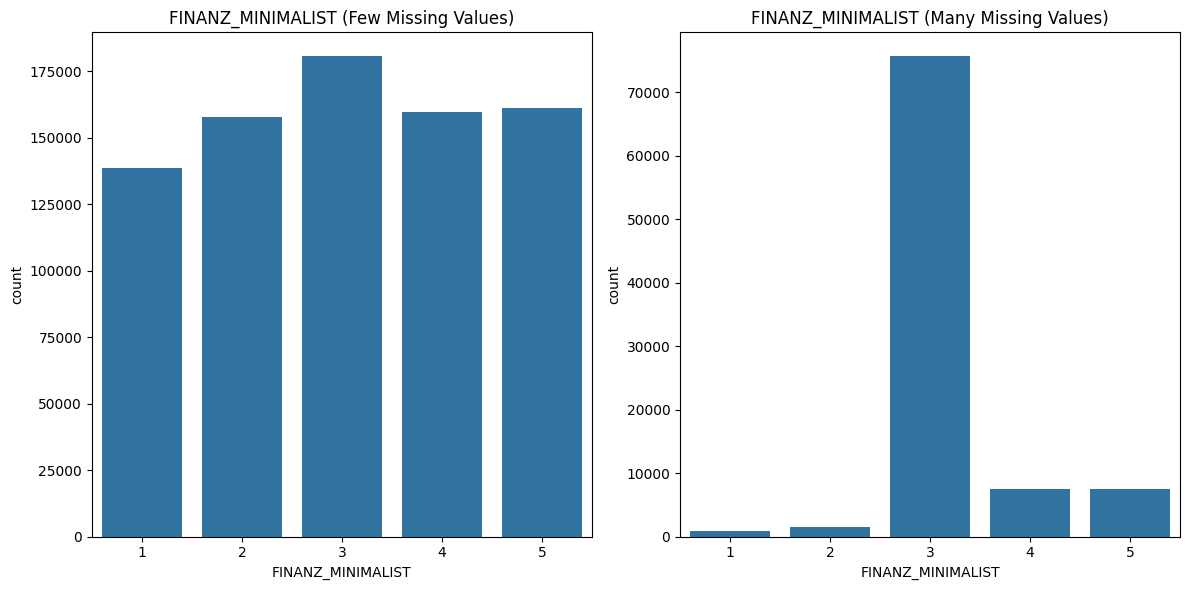

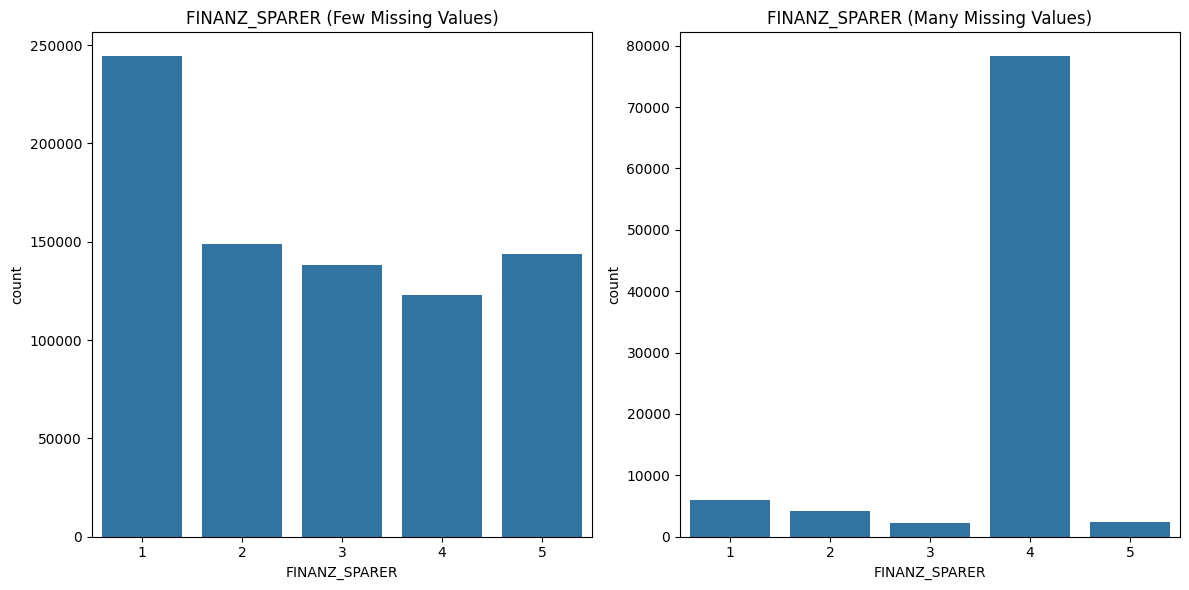

In [26]:
for column in top_few_missing_cols:
    compare_distributions(
        column,
        azdias_low_missing,
        azdias_high_missing,
        title1=f'{column} (Few Missing Values)',
        title2=f'{column} (Many Missing Values)'
    )

#### Discussion 1.1.3: Assess Missing Data in Each Row


Rows with few or no missing values: 797982
Rows with many missing values: 93239

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# Remove outlier columns from feat_info
feat_info_cleaned = feat_info[~feat_info['attribute'].isin(num_null_outlier_cols)]

print("Shape of feat_info before removal:", feat_info.shape)
print("Shape of feat_info after removal:", feat_info_cleaned.shape)

Shape of feat_info before removal: (85, 4)
Shape of feat_info after removal: (79, 4)


In [28]:
# How many features are there of each data type?
num_feature_type = feat_info_cleaned['type'].value_counts()

# Display the counts
print("Number of features by type:")
print(num_feature_type)

Number of features by type:
type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
azdias_cleaned = azdias_low_missing.fillna(azdias_low_missing.mode().iloc[0])


In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()

# Ensure the features exist in the cleaned dataset
categorical_features = [feature for feature in categorical_features if feature in azdias_cleaned.columns]

print("Categorical features:", categorical_features)

Categorical features: ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [31]:
# Separate binary and multi-level categorical features
binary_features = []
multi_level_features = []

for feature in categorical_features:
    unique_values = azdias_cleaned[feature].nunique()
    if unique_values == 2:
        binary_features.append(feature)
    elif unique_values > 2:
        multi_level_features.append(feature)

print("Binary categorical features:", binary_features)
print("Multi-level categorical features:", multi_level_features)

Binary categorical features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level categorical features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


#### Discussion 1.2.1: Re-Encode Categorical Features

The categorical variables were classified into two categories: binary (which were re-encoded to 0 and 1) and multi-level (which were removed from the analysis to simplify the data).

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.



In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Mapping for Decade
decade_dict = {
    1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
    8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
}

# Mapping for Movement
movement_dict = {
    1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1,
    8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1
}

# Create Decade and Movement features
azdias_cleaned['Decade'] = azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
azdias_cleaned['Movement'] = azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)

# Drop the original feature
azdias_cleaned = azdias_cleaned.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

print(azdias_cleaned[['Decade', 'Movement']].head())



   Decade  Movement
1      90         0
2      90         1
3      70         0
4      70         0
5      50         0


In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Convert CAMEO_INTL_2015 to numeric, setting invalid values to NaN
azdias_cleaned['CAMEO_INTL_2015'] = pd.to_numeric(azdias_cleaned['CAMEO_INTL_2015'], errors='coerce')

# Extract Wealth and Life_Stage
azdias_cleaned['Wealth'] = azdias_cleaned['CAMEO_INTL_2015'] // 10
azdias_cleaned['Life_Stage'] = azdias_cleaned['CAMEO_INTL_2015'] % 10

# Drop the original feature
azdias_cleaned = azdias_cleaned.drop(columns=['CAMEO_INTL_2015'])

# Verify the new features
print(azdias_cleaned[['Wealth', 'Life_Stage']].head())

   Wealth  Life_Stage
1     5.0         1.0
2     2.0         4.0
3     1.0         2.0
4     4.0         3.0
5     5.0         4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

I directly mapped the values of PRAEGENDE_JUGENDJAHRE to create the Decade and Movement features using dictionaries and vectorized operations.

I used pd.to_numeric with errors='coerce' to handle non-numeric values (e.g., 'XX') by converting them to NaN, then performed arithmetic operations (// and %) to extract Wealth and Life_Stage.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# Check the data types of the final columns

mixed_variables = feat_info[feat_info.type=="mixed"]

for mixed_feature in mixed_variables["attribute"]:
    if mixed_feature in azdias_cleaned.columns:
        azdias_cleaned.drop(mixed_feature,axis=1,inplace=True)


In [35]:
print('Number of observations in the dataset:', azdias_cleaned.shape[0])
print('NaN values in the dataset:', azdias_cleaned.isna().sum().sum())

Number of observations in the dataset: 798067
NaN values in the dataset: 744


In [36]:
# Fill NaNs
imputer = SimpleImputer(strategy='most_frequent')
matrix_values = imputer.fit_transform(azdias_cleaned)
azdias_cleaned = pd.DataFrame(matrix_values, columns=azdias_cleaned.columns)

In [37]:
print('Number of observations in the dataset:', azdias_cleaned.shape[0])
print('NaN values in the dataset:', azdias_cleaned.isna().sum().sum())

Number of observations in the dataset: 798067
NaN values in the dataset: 0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [38]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.

    INPUT:
        df (DataFrame): Demographics DataFrame.
        feat_info (DataFrame): Feature summary DataFrame containing missing value codes.

    OUTPUT:
        df_cleaned (DataFrame): Trimmed and cleaned demographics DataFrame.
    """
    # Step 1: Convert missing value codes to NaNs
    for index, row in feat_info.iterrows():
        column = row['attribute']
        missing_values = row['missing_or_unknown']

        if column in df.columns:
            if missing_values != '[]':
                # Parse missing value codes (e.g., "[-1, 0]" -> [-1, 0])
                missing_codes = missing_values.strip('[]').split(',')
                missing_codes = [int(code) if code.lstrip('-').isdigit() else code.strip() for code in missing_codes]

                # Replace missing value codes with NaN
                df[column] = df[column].replace(missing_codes, np.nan)

    # Step 2: Drop columns and rows with excessive missing values
    missing_per_column = df.isna().mean()
    columns_to_drop = missing_per_column[missing_per_column > 0.3].index.tolist()
    df = df.drop(columns=columns_to_drop)

    missing_per_row = df.isna().sum(axis=1)
    df = df[missing_per_row <= 10]

    # Step 3: Re-encode binary categorical features
    binary_features = []
    for column in df.columns:
        if df[column].nunique() == 2 and df[column].dtype == 'object':
            binary_features.append(column)

    for column in binary_features:
        df[column] = df[column].astype('category').cat.codes  # Convert to numeric codes

    # Step 4: Re-encode multi-level categorical features using one-hot encoding
    multi_level_features = []
    for column in df.columns:
        if df[column].nunique() > 2 and df[column].dtype == 'object':
            multi_level_features.append(column)

    # Ensure consistent one-hot encoding by including all possible categories
    df = pd.get_dummies(df, columns=multi_level_features, drop_first=False)

    # Step 5: Engineer features from mixed-type columns
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        decade_dict = {
            1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
            8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
        }
        movement_dict = {
            1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1,
            8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1
        }

        df['Decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
        df['Movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
        df = df.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

    if 'CAMEO_INTL_2015' in df.columns:
        df['Wealth'] = pd.to_numeric(df['CAMEO_INTL_2015'], errors='coerce') // 10
        df['Life_Stage'] = pd.to_numeric(df['CAMEO_INTL_2015'], errors='coerce') % 10
        df = df.drop(columns=['CAMEO_INTL_2015'])

    for mixed_feature in mixed_variables["attribute"]:
        if mixed_feature in df.columns:
            df.drop(mixed_feature,axis=1,inplace=True)

    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Identify columns with non-numeric data (categorical data)
categorical_columns = azdias_cleaned.select_dtypes(include=['object']).columns

# If you want to encode categorical columns, here's one way to do it (Label Encoding):
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    azdias_cleaned[col] = label_encoder.fit_transform(azdias_cleaned[col])

# Now apply feature scaling to the general population demographics data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(azdias_cleaned)

# Convert the scaled features back into a DataFrame
features_scaled = pd.DataFrame(features_scaled, columns=azdias_cleaned.columns.tolist())

# Display the first few rows of the scaled data
features_scaled.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_count,Decade,Movement,Wealth,Life_Stage
0,-1.766647,0.957912,0.974332,-1.494594,1.537920,-1.040686,1.465965,0.958633,1.339319,-1.342038,0.698526,-0.530407,1.010156,0.308666,0.401372,-0.786185,-0.960530,-0.346454,-1.685452,0.443205,-0.059355,0.002834,-0.463909,-1.684507,-1.109913,-1.435372,-0.578164,1.274185,-0.312196,1.339262,-0.157565,1.518699,1.288987,1.434333,10.85417,0.922940,1.151759,0.235271,-0.060477,1.026720,-0.730192,0.567332,0.182813,-0.125619,1.921561,-1.304533,-0.383167,0.517425,0.980501,0.925947,-1.008836,-0.965690,-0.594874,2.730674,-1.659274,0.845251,-0.547161,1.701105,-0.799742,-0.791629,-1.279712,0.166966,-0.882469,1.146369,-0.256528,0.211982,0.402977,0.442535,1.455855,0.574309,-0.171399,-0.127042,0.684885,-0.414827,1.098064,-0.530407,1.175655,-1.248888
1,0.200522,0.957912,-0.329868,-1.494594,0.864560,-1.766972,-0.570999,0.244109,1.339319,-1.342038,0.698526,1.885345,1.010156,-0.717130,-0.784149,-0.502246,-0.298869,-0.346454,-0.310902,-0.072013,-1.626994,-0.520587,-0.463909,-0.142554,-0.158741,0.754262,-0.578164,0.064233,1.391992,1.339262,1.448745,-0.638942,-0.410210,0.443769,-0.09213,-1.083494,1.151759,-0.631949,-0.060477,-0.267573,-0.730192,0.567332,0.116015,-0.125619,-0.703271,1.274844,-0.383167,0.517425,-0.625389,-0.690543,-0.297919,1.444756,0.408133,-0.464084,-0.116192,-0.986687,0.034482,-0.271086,0.283466,-0.791629,0.092849,-0.476480,-1.435271,0.322301,0.786631,0.211982,-0.623111,-0.934791,0.419746,0.574309,-0.171399,-0.127042,-0.789025,-0.414827,1.098064,1.885345,-0.869682,0.767097
2,1.184107,0.957912,-0.981968,0.683145,-0.482159,1.138172,-0.570999,-1.184938,-0.791197,1.056389,-1.814355,-0.530407,-0.311824,-0.717130,-0.784149,1.201390,1.024455,-0.346454,-0.998177,0.443205,-1.626994,-1.044008,-1.509281,-0.142554,-0.158741,1.301671,-0.067376,-0.540743,-0.312196,-0.303542,0.377872,-0.099532,0.156189,-0.546795,-0.09213,-1.083494,-0.268923,-1.499169,-0.060477,-2.209012,0.957029,0.567332,-0.485163,-0.125619,-0.703271,0.630000,1.117198,0.517425,-1.428334,-1.498788,1.834830,-0.162208,-0.594874,-0.464084,0.655349,-0.070718,-1.128805,0.715010,0.283466,0.269703,0.779129,-1.119927,0.775936,-0.058543,-0.256528,-0.890125,0.402977,-0.934791,-0.616363,0.574309,-1.173149,-0.997550,-0.052070,1.872286,-0.267784,-0.530407,-1.551461,-0.576893
3,0.200522,-1.043937,0.974332,0.683145,0.191200,0.411886,-1.249987,0.244109,-0.791197,0.576704,-0.697519,-0.530407,1.010156,1.590911,1.586893,-0.502246,-0.298869,-0.346454,1.063648,0.958423,-0.059355,0.002834,-0.986595,1.399399,-0.158741,-0.340555,0.954200,-1.145720,-0.880259,-1.398745,-1.228438,-0.099532,-0.976609,0.443769,-0.09213,0.922940,0.441418,1.969710,-0.060477,0.379574,-1.292599,0.567332,-0.351568,-0.125619,-0.703271,0.630000,-0.383167,0.517425,0.177556,0.117702,-0.297919,2.248238,0.408133,-0.464084,-0.116192,-0.986687,0.616126,-1.750229,1.366673,0.269703,0.092849,1.453859,0.223134,-0.587129,-0.256528,1.314088,0.402977,0.442535,-0.616363,-0.337194,0.830351,0.308212,1.421840,-0.414827,-0.267784,-0.530407,0.493876,0.095102
4,-1.766647,0.957912,-0.981968,-0.042

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [40]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(features_scaled)


PCA()

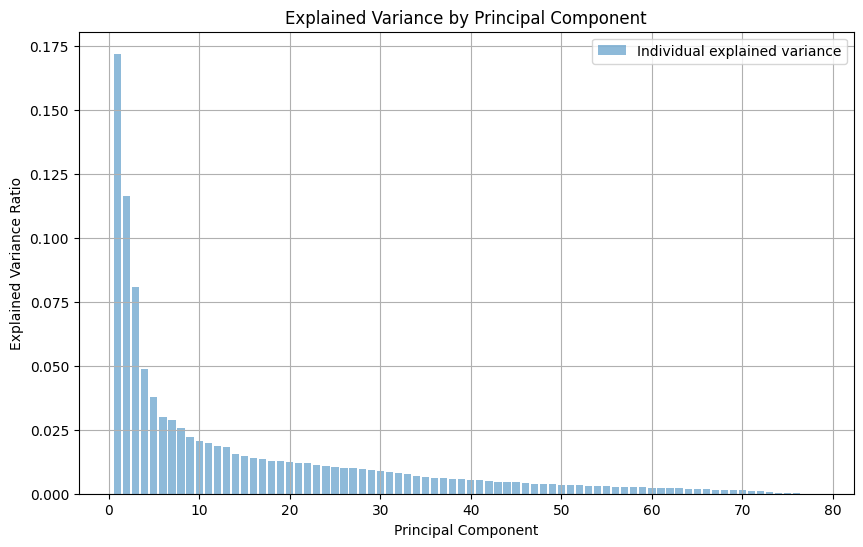

In [41]:
# Investigate the variance accounted for by each principal component.
# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance and cumulative explained variance
plt.figure(figsize=(10, 6))

# Plot individual explained variance
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component')
plt.legend(loc='best')
plt.grid(True)
plt.show()

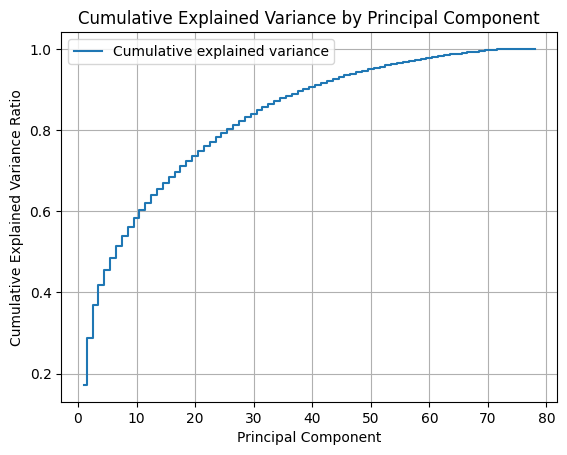

In [42]:
# Calculate the cumulative explained variance
cumulative_explained_variance = explained_variance_ratio.cumsum()
# Plot cumulative explained variance
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance by Principal Component')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [43]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Choose the number of components
n_components = 50

pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features_scaled)

# Check the shape of the transformed data
print("Shape of PCA-transformed data:", features_pca.shape)

Shape of PCA-transformed data: (798067, 50)


### Discussion 2.2: Perform Dimensionality Reduction
PCA reduces the dimensionality of the data by finding the principal components of maximum variance.

Re-fit PCA with the selected number of components to perform the final transformation.

The plots showed the individual and cumulative explained variance for each principal component.

There's an elbow point where the cumulative variance starts to level off.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [44]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_weights(pca, features, component_index):
    # Get the feature weights for the specified component
    component_weights = pca.components_[component_index]

    # Create a DataFrame to map feature names to their weights
    weights_df = pd.DataFrame({
        'Feature': features,
        'Weight': component_weights
    })

    # Sort the DataFrame by absolute weight (to find the most influential features)
    weights_df['Absolute Weight'] = weights_df['Weight'].abs()
    weights_df = weights_df.sort_values(by='Absolute Weight', ascending=False)

    # Print the sorted feature weights
    print(f"Feature weights for Principal Component {component_index + 1}:")
    print(weights_df[['Feature', 'Weight']].head(10))  # Top 10 features
    print("\n")

In [45]:
# Get the feature names from the original dataset
feature_names = azdias_cleaned.columns.tolist()

In [46]:
print_weights(pca, feature_names, component_index=0)  # First principal component


Feature weights for Principal Component 1:
               Feature    Weight
15      LP_STATUS_FEIN -0.218400
16      LP_STATUS_GROB -0.217263
49      CAMEO_DEU_2015  0.206861
48     CAMEO_DEUG_2015  0.205120
60          MOBI_REGIO -0.203834
76              Wealth  0.201714
3    FINANZ_MINIMALIST -0.199684
64          PLZ8_ANTG1 -0.199604
39  HH_EINKOMMEN_SCORE  0.198647
66          PLZ8_ANTG3  0.198002




In [47]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_weights(pca, feature_names, component_index=1)  # Second principal component

Feature weights for Principal Component 2:
                  Feature    Weight
0    ALTERSKATEGORIE_GROB  0.263324
21              SEMIO_REL -0.255863
74                 Decade -0.247320
4           FINANZ_SPARER -0.245187
5        FINANZ_VORSORGER  0.236218
31          SEMIO_PFLICHT -0.233343
7   FINANZ_UNAUFFAELLIGER -0.233098
32            SEMIO_TRADV -0.231328
25              SEMIO_ERL  0.223818
26             SEMIO_KULT -0.210414




In [48]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_weights(pca, feature_names, component_index=2)  # Third principal component

Feature weights for Principal Component 3:
       Feature    Weight
1    ANREDE_KZ -0.363615
23  SEMIO_VERT  0.336953
30  SEMIO_KAEM -0.333196
29   SEMIO_DOM -0.308849
28  SEMIO_KRIT -0.273994
19   SEMIO_SOZ  0.260667
20   SEMIO_FAM  0.254785
26  SEMIO_KULT  0.243050
27   SEMIO_RAT -0.200459
25   SEMIO_ERL -0.186197




### Discussion 2.3: Interpret Principal Components

**PC1**: Reflects social status and housing density, distinguishing affluent urban areas from less affluent rural areas.

**PC2**: Reflects age, financial behavior, and personality traits, distinguishing older, financially prepared individuals from younger, money-conscious, and traditional individuals.

**PC3**: Reflects personality traits and gender, distinguishing assertive, dominant personalities from dreamful, family-oriented ones.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [49]:
from sklearn.cluster import KMeans

# Over a number of different cluster counts...
inertia = []
cluster_counts = range(1, 21)

for k in cluster_counts:
    print(f"Fitting k-means with {k} clusters...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_pca)
    inertia.append(kmeans.inertia_)

Fitting k-means with 1 clusters...
Fitting k-means with 2 clusters...
Fitting k-means with 3 clusters...
Fitting k-means with 4 clusters...
Fitting k-means with 5 clusters...
Fitting k-means with 6 clusters...
Fitting k-means with 7 clusters...
Fitting k-means with 8 clusters...
Fitting k-means with 9 clusters...
Fitting k-means with 10 clusters...
Fitting k-means with 11 clusters...
Fitting k-means with 12 clusters...
Fitting k-means with 13 clusters...
Fitting k-means with 14 clusters...
Fitting k-means with 15 clusters...
Fitting k-means with 16 clusters...
Fitting k-means with 17 clusters...
Fitting k-means with 18 clusters...
Fitting k-means with 19 clusters...
Fitting k-means with 20 clusters...


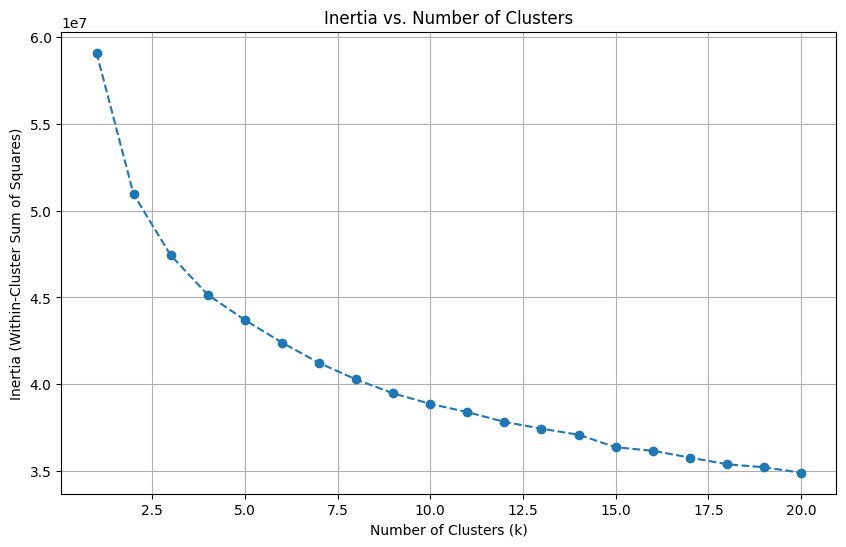

In [50]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# Plot the inertia vs. number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Inertia vs. Number of Clusters')
plt.grid(True)
plt.show()

In [51]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

optimal_clusters = 5  # Optimal number of clusters (based on the elbow point)

# Re-fit k-means with the selected number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(features_pca)

# Obtain cluster assignments for the general population data
general_population_clusters = kmeans.predict(features_pca)

### Discussion 3.1: Apply Clustering to General Population

The plot showed the inertia decreasing as the number of clusters increases.

The elbow point (I choose 5 clusters) indicates the optimal number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [52]:
# Load in the customer demographics data.
customers = pd.read_csv('/workspace/cd0026/Identify_Customer_Segments/Udacity_CUSTOMERS_Subset.csv', sep=';')

In [53]:
customers.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [54]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers, feat_info)


In [55]:
columns_to_drop = [
    'CAMEO_INTL_2015_12', 'CAMEO_INTL_2015_13', 'CAMEO_INTL_2015_14', 'CAMEO_INTL_2015_15',
    'CAMEO_INTL_2015_22', 'CAMEO_INTL_2015_23', 'CAMEO_INTL_2015_24', 'CAMEO_INTL_2015_25',
    'CAMEO_INTL_2015_31', 'CAMEO_INTL_2015_32', 'CAMEO_INTL_2015_33', 'CAMEO_INTL_2015_34',
    'CAMEO_INTL_2015_35', 'CAMEO_INTL_2015_41', 'CAMEO_INTL_2015_43', 'CAMEO_INTL_2015_44',
    'CAMEO_INTL_2015_45', 'CAMEO_INTL_2015_51', 'CAMEO_INTL_2015_52', 'CAMEO_INTL_2015_54',
    'CAMEO_INTL_2015_55', 'Decade', 'Movement'
]

# Drop the columns from the dataset
customers_cleaned.drop(columns=columns_to_drop, axis=1, inplace=True)


In [56]:
to_drop = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN']
customers_cleaned.drop(columns=to_drop, axis=1, inplace=True)

In [57]:
to_drop2 = ['LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP']
customers_cleaned.drop(columns=to_drop2, axis=1, inplace=True)

In [58]:
to_drop3 = ['ZABEOTYP']
customers_cleaned.drop(columns=to_drop3, axis=1, inplace=True)

In [59]:

imputer = SimpleImputer(strategy='most_frequent')
matrix_values = imputer.fit_transform(customers_cleaned)
customers_cleaned = pd.DataFrame(matrix_values, columns=customers_cleaned.columns)

In [60]:
print('NaN values in the customers dataset after cleaning:', customers_cleaned.isna().sum().sum())

NaN values in the customers dataset after cleaning: 0


In [61]:
new_set = set(features_scaled.columns) - set(customers_cleaned.columns)

In [62]:
print(new_set)

{'missing_count', 'GEBAEUDETYP', 'Movement', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 'REGIOTYP', 'FINANZTYP', 'Life_Stage', 'ZABEOTYP', 'KKK', 'Wealth', 'CAMEO_DEUG_2015', 'Decade', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'LP_FAMILIE_FEIN', 'CAMEO_DEU_2015', 'LP_STATUS_FEIN'}


In [63]:
customers_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,1.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,4.0,3.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,1.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,1.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,3.0,6.0,5.0,3.0,4.0,7.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,0.0,1.0,0.0,0.0,4.0,6.0,9.0,1.0,0.0,2.0,1992.0,1.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,4.0,2.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,5.0,4.0,5.0,4.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,5.0,4.0,0.0,2.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,1.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,3.0,5.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,3.0,6.0,4.0,4.0,1.0,7.0,6.0,4.0,6.0,2.0,5.0,5.0,3.0,3.0,4.0,0.0,2.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,1.0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,5.0,5.0,3.0,7.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
print(len(customers_cleaned.columns))
for col in customers_cleaned.columns:
    print(col)

111
ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SOHO_KZ
VERS_TYP
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
MOBI_REGIO
ONLINE_AFFINITAET
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CAMEO_DEUG_2015_1
CAMEO_DEUG_2015_2
CAMEO_DEUG_2015_3
CAMEO_DEUG_2015_4
CAMEO_DEUG_2015_5
CAMEO_DEUG_2015_6
CAMEO_DEUG_2015_7
CAMEO_DEUG_2015_8
CAMEO_DEUG_2015_9
CAMEO_DEU_2015_1A
CAMEO_DEU_2015_1B
CAMEO_DEU_2015_1C
CAMEO_DEU_2015_1D
CAMEO_DEU_2015_1E
CAMEO_DEU_2

In [65]:
print("Columns in features_scaled:", features_scaled.columns.tolist())
print("Columns in customers_cleaned:", customers_cleaned.columns.tolist())

Columns in features_scaled: ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_R

In [66]:
for column in new_set:
    customers_cleaned[column] = 0

In [67]:
print(len(customers_cleaned.columns))
for col in customers_cleaned.columns:
    print(col)

131
ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SOHO_KZ
VERS_TYP
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
MOBI_REGIO
ONLINE_AFFINITAET
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CAMEO_DEUG_2015_1
CAMEO_DEUG_2015_2
CAMEO_DEUG_2015_3
CAMEO_DEUG_2015_4
CAMEO_DEUG_2015_5
CAMEO_DEUG_2015_6
CAMEO_DEUG_2015_7
CAMEO_DEUG_2015_8
CAMEO_DEUG_2015_9
CAMEO_DEU_2015_1A
CAMEO_DEU_2015_1B
CAMEO_DEU_2015_1C
CAMEO_DEU_2015_1D
CAMEO_DEU_2015_1E
CAMEO_DEU_2

In [68]:
feature_order = features_scaled.columns.tolist()


In [69]:
customers_cleaned = customers_cleaned[feature_order]
# scalling
customers_scaled = scaler.transform(customers_cleaned)
customers_scaled = pd.DataFrame(customers_scaled, columns=customers_cleaned.columns)

# PCA transformation
customers_pca = pca.transform(customers_scaled)

# kmeans prediction
customers_preds = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [70]:
# Add cluster assignments to the original DataFrame
azdias_cleaned['Cluster'] = general_population_clusters

print("Cluster assignments for the general population:")
print(azdias_cleaned['Cluster'].value_counts())

Cluster assignments for the general population:
Cluster
3    195250
0    161569
1    153302
4    146321
2    141625
Name: count, dtype: int64


In [71]:
# Add cluster assignments to the original DataFrame
customers_cleaned['Cluster'] = customers_preds

print("Cluster assignments for the general population:")
print(customers_cleaned['Cluster'].value_counts())

Cluster assignments for the general population:
Cluster
2    139259
Name: count, dtype: int64


Cluster Proportions:
         General Population  Customer Data
Cluster                                   
0                  0.202450            NaN
1                  0.192092            NaN
2                  0.177460            1.0
3                  0.244654            NaN
4                  0.183344            NaN


<Figure size 1200x600 with 0 Axes>

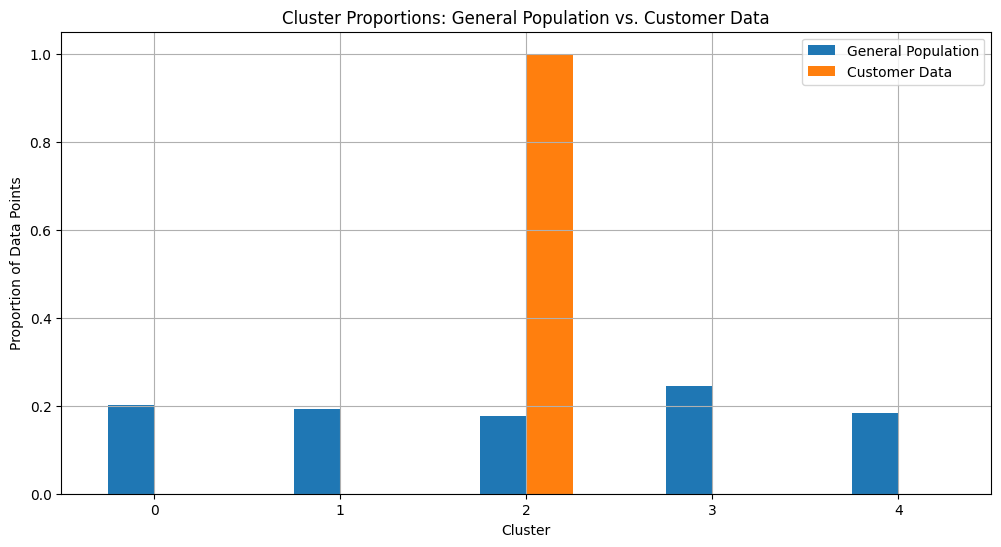

In [72]:
# Compute cluster proportions
general_population_cluster_counts = azdias_cleaned['Cluster'].value_counts(normalize=True).sort_index()
general_population_cluster_counts = general_population_cluster_counts.rename('General Population')

customer_cluster_counts = customers_cleaned['Cluster'].value_counts(normalize=True).sort_index()
customer_cluster_counts = customer_cluster_counts.rename('Customer Data')

cluster_proportions = pd.concat([general_population_cluster_counts, customer_cluster_counts], axis=1)
print("Cluster Proportions:")
print(cluster_proportions)

# Visualize cluster proportions
plt.figure(figsize=(12, 6))
cluster_proportions.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Cluster')
plt.ylabel('Proportion of Data Points')
plt.title('Cluster Proportions: General Population vs. Customer Data')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

In [73]:
# Identify overrepresented and underrepresented clusters
cluster_proportions['Difference'] = cluster_proportions['Customer Data'] - cluster_proportions['General Population']

overrepresented_clusters = cluster_proportions[cluster_proportions['Difference'] > 0]
print("Overrepresented Clusters:")
print(overrepresented_clusters)

underrepresented_clusters = cluster_proportions[cluster_proportions['Difference'] < 0]
print("Underrepresented Clusters:")
print(underrepresented_clusters)

Overrepresented Clusters:
         General Population  Customer Data  Difference
Cluster                                               
2                   0.17746            1.0     0.82254
Underrepresented Clusters:
Empty DataFrame
Columns: [General Population, Customer Data, Difference]
Index: []


In [74]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_0 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[0]).reshape(1, -1))


In [75]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_4 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[4]).reshape(1, -1))
len(centroid_0)

1

In [76]:
len(centroid_4)


1

In [77]:
centroids=pd.Series({"feature":customers_cleaned.columns,"centroid_0":centroid_0,"centroid_4":centroid_4})


In [78]:
centroids=pd.DataFrame(centroids)


In [79]:
centroids

,0
feature,"Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'C..."
centroid_0,"[[0.8330994297902493, 0.5374019587920565, 3.05..."
centroid_4,"[[2.4448846061115903, 0.9549610698043993, 2.21..."


### Discussion 3.3: Compare Customer Data to Demographics Data
Overrepresented Cluster (Centroid 2):
This cluster is overrepresented, showing financially cautious planners with high socio-economic status and moderate to low investment activity. They likely live in higher-tier buildings and are older.

Underrepresented Clusters:
No underrepresented clusters in the customer data.

Conclusion:
The customer data is heavily focused on financially cautious individuals with a strong focus on financial security, likely older, and from higher social classes. This insight can help refine customer targeting strategies.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.